# Feature Extraction

In [1]:
from keras.applications import VGG16
#VGG16 : Convolution layers 13 / fully connected layers 3
#VGG19 : Convolution layers 16 / fully connected layers 3

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights = 'imagenet' , #초기화할 가중치 체크포인트 지정
                 include_top = False, #최상위 완전 연결 분규리를 포함할지 안 할지(default 클래스 1000에 대응되는 분류기 포함)
                 input_shape = (150,150,3)) #네트워크에 주입할 이밎 텐서의 크기. 만약 include_top = True이면, 완전 연결 층이 추가되기 때문에 원본 모델과 동일해야 함

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## not using Data Augmentation
- 새로운 데이터셋에서 CNN layer를 실행하고, 출력을 numpy array로 디스크에 저장.
- 독립된 완전 연결 분류기에 입력으로 사용.
- 모든 이미지에 CNN층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듬

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
os.listdir('./data')

['cats_vs_dogs', 'cats_vs_dogs_small']

In [7]:
base_dir = './data/cats_vs_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [11]:
def extract_features(directory, sample_count) :
    features = np.zeros(shape = (sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    
    generator = datagen.flow_from_directory(
        directory, target_size = (150,150),
        batch_size = batch_size, class_mode='binary'
    )
    
    i = 0
    for input_batch, label_batch in generator :
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = label_batch
        i += 1
        
        if i *batch_size >= sample_count :
            break #제너레이터는 루프 안에서 무한히 데이터를 만들어 내므로, 모든 이미지를 한 번씩 처리하고 나면 중지하도록
    
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
#완전 연결 분류기에 주입하기 위해 shape을 맞춰준다
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [17]:
from keras import models
from keras import layers
from keras import optimizers

In [18]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy', metrics = ['acc'])

history = model.fit(train_features, train_labels,
                   epochs = 30, batch_size = 20,
                   validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.5974 - acc: 0.6665 - val_loss: 0.4433 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 0s 134us/step - loss: 0.4220 - acc: 0.8150 - val_loss: 0.3621 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 0s 137us/step - loss: 0.3576 - acc: 0.8490 - val_loss: 0.3214 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 0s 135us/step - loss: 0.3182 - acc: 0.8630 - val_loss: 0.3023 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 0s 134us/step - loss: 0.2855 - acc: 0.8795 - val_loss: 0.2859 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 0s 135us/step - loss: 0.2594 - acc: 0.8955 - val_loss: 0.2733 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 0s 134us/step - loss: 0.2543 - acc: 0.8940 - val_loss: 0.2688 - val_acc: 0.8940


In [19]:
import matplotlib.pyplot as plt

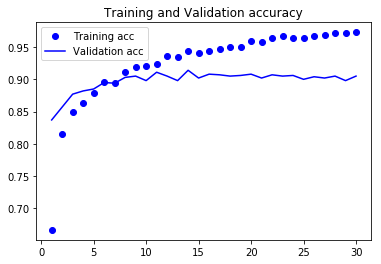

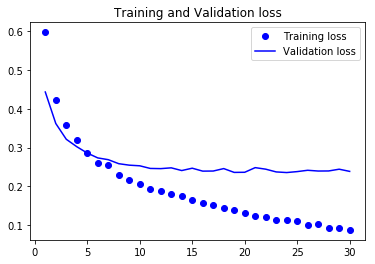

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc,'bo', label = 'Training acc')
plt.plot(epochs, val_acc,'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

- 몇 번의 epoch을 돌지 않았고, dropout을 50% 했음에도 거의 바로 overfitting 된다.
- 데이터 증식을 사용하지 않았기 때문ㅇ

## using Data Augmentation
- conv_base 위에 Dense 층을 쌓아 확장
- 입력 데이터에서 end-to-end 모델을 실행
- 모델에 노출된 모든 입력 이미지가 매번 CNN laeyr를 통과하기 때문에 데이터 증식
- 비용이 많이 듬

In [22]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [25]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수 : ', len(model.trainable_weights))
conv_base.trainable = False #freezing하지 않으면, 사전에 학습된 표현이 훈련하는 동안 수정됨
print('conv_base를 동결한 후 훈련되는 가중치의 수 : ', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 :  30
conv_base를 동결한 후 훈련되는 가중치의 수 :  4


In [27]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, rotation_range = 40,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) #never augmetnation valdiation data

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14255069999815139056
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10923252122
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 5325378283696047205
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10925244416
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12323023228327281205
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [29]:
import keras.backend.tensorflow_backend as K

In [33]:
with K.tf.device("/gpu:0"):
    model.compile(loss = 'binary_crossentropy',
                 optimizer=optimizers.RMSprop(lr = 2e-5),
                 metrics=['acc'])
    history = model.fit_generator(train_generator,
                       steps_per_epoch=100, epochs=30,
                       validation_data=validation_generator, validation_steps=50,
                       verbose = 2)

Epoch 1/30
 - 14s - loss: 0.5795 - acc: 0.7145 - val_loss: 0.4570 - val_acc: 0.8110
Epoch 2/30
 - 13s - loss: 0.4755 - acc: 0.7870 - val_loss: 0.3791 - val_acc: 0.8530
Epoch 3/30
 - 12s - loss: 0.4273 - acc: 0.8150 - val_loss: 0.3391 - val_acc: 0.8680
Epoch 4/30
 - 12s - loss: 0.3911 - acc: 0.8315 - val_loss: 0.3174 - val_acc: 0.8720
Epoch 5/30
 - 13s - loss: 0.3864 - acc: 0.8230 - val_loss: 0.2998 - val_acc: 0.8810
Epoch 6/30
 - 12s - loss: 0.3708 - acc: 0.8430 - val_loss: 0.2907 - val_acc: 0.8800
Epoch 7/30
 - 12s - loss: 0.3528 - acc: 0.8485 - val_loss: 0.2844 - val_acc: 0.8830
Epoch 8/30
 - 13s - loss: 0.3481 - acc: 0.8535 - val_loss: 0.2774 - val_acc: 0.8770
Epoch 9/30
 - 13s - loss: 0.3430 - acc: 0.8540 - val_loss: 0.2685 - val_acc: 0.8860
Epoch 10/30
 - 13s - loss: 0.3383 - acc: 0.8505 - val_loss: 0.2633 - val_acc: 0.8890
Epoch 11/30
 - 12s - loss: 0.3302 - acc: 0.8575 - val_loss: 0.2559 - val_acc: 0.8930
Epoch 12/30
 - 13s - loss: 0.3412 - acc: 0.8500 - val_loss: 0.2539 - val_a

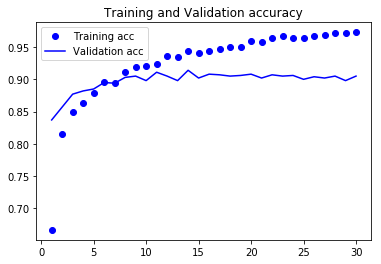

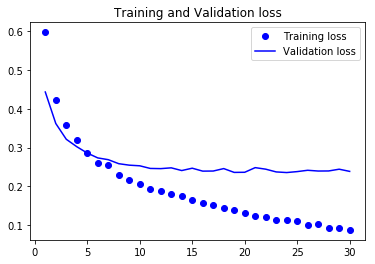

In [34]:
plt.plot(epochs, acc,'bo', label = 'Training acc')
plt.plot(epochs, val_acc,'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# Fine Tuning
- 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것
- 조금더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라 함

## step
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추구한 네트워크 훈련
4. 기반 네트워크에서 일부 층의 동결을 해제
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

![image](https://camo.qiitausercontent.com/dbab53aa72f4788279c5de82580928077e331880/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3332323237392f34326462333163632d616461642d333265342d326338352d6632376333313962633235372e706e67)

In [36]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

마지막 3개의 합성곱 층을 미세 조정하겠다. (block5_conv1부터 학습)

## 왜 더 많은 층을 미세 조정하지 않을까?
- 하위 층들이 좀 더 일반적이고 재사용 가능한 특성들을 가지고 있다
- 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커진다

In [38]:
for layer in conv_base.layers :
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [40]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers :
    if layer.name == 'block5_conv1' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
        
    else :
        layer.trainable = False

In [41]:
with K.tf.device("/gpu:0"):
    model.compile(loss = 'binary_crossentropy',
                 optimizer=optimizers.RMSprop(lr = 1e-5),
                 metrics = ['acc'])

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=100, epochs=100,
        validation_data=validation_generator,
        validation_steps=50
    )

Epoch 1/100
100/100 [==============================] - 14s 140ms/step - loss: 0.2699 - acc: 0.8830 - val_loss: 0.2382 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 13s 126ms/step - loss: 0.2513 - acc: 0.8965 - val_loss: 0.2064 - val_acc: 0.9120
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 0.2645 - acc: 0.8835 - val_loss: 0.1853 - val_acc: 0.9250
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 0.2170 - acc: 0.9110 - val_loss: 0.1914 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 0.2128 - acc: 0.9160 - val_loss: 0.2225 - val_acc: 0.9070
Epoch 6/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1884 - acc: 0.9220 - val_loss: 0.2347 - val_acc: 0.9120
Epoch 7/100
100/100 [==============================] - 13s 127ms/step - loss: 0.1940 - acc: 0.9180 - val_loss: 0.1687 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 12s 125ms/step - loss: 0.0295 - acc: 0.9895 - val_loss: 0.2850 - val_acc: 0.9270
Epoch 62/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0260 - acc: 0.9905 - val_loss: 0.2525 - val_acc: 0.9350
Epoch 63/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0358 - acc: 0.9865 - val_loss: 0.2360 - val_acc: 0.9310
Epoch 64/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0305 - acc: 0.9885 - val_loss: 0.2486 - val_acc: 0.9340
Epoch 65/100
100/100 [==============================] - 13s 129ms/step - loss: 0.0304 - acc: 0.9865 - val_loss: 0.1868 - val_acc: 0.9430
Epoch 66/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0255 - acc: 0.9920 - val_loss: 0.2574 - val_acc: 0.9320
Epoch 67/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0288 - acc: 0.9880 - val_loss: 0.3857 - val_acc: 0.9090
Epoch 68/100
100/100 [===================

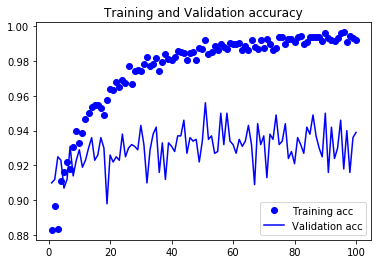

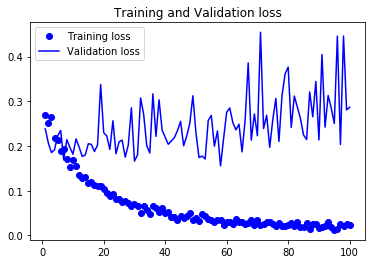

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc,'bo', label = 'Training acc')
plt.plot(epochs, val_acc,'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## smooth curve

In [45]:
def smooth_curve(points, factor = 0.8) :
    smoothed_points = []
    
    for point in points :
        if smoothed_points :
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point*(1-factor))
            
        else :
            smoothed_points.append(point)
            
    return smoothed_points
        

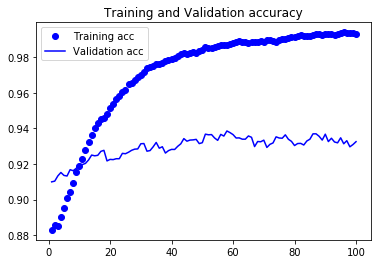

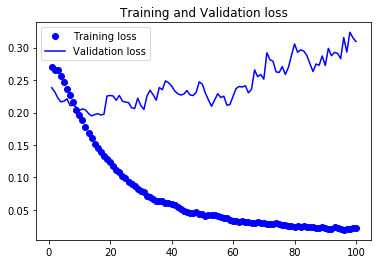

In [46]:
plt.plot(epochs, smooth_curve(acc),'bo', label = 'Training acc')
plt.plot(epochs, smooth_curve(val_acc),'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

- loss curve는 오히려 감소하는 것이 아니라 상승한다
- 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아님
- 모델이 향상되더라도 평균 손실에 반영되지 않을 수 있음

In [47]:
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


- `predict_generator` : takes your test data and gives you the output.

- `evaluate_generator` :  uses both your test input and output. It first predicts output using training input and then evaluates performance by comparing it against your test output. So it gives out a measure of performance, i.e. accuracy in your case.


In [48]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc : ', test_acc)

test acc :  0.9359999895095825
